In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

In [28]:
df_genTech = pd.read_csv(r"data\TechnicalDataofGeneratingUnits-Table1.csv")

df_gen = pd.read_csv(r"data\CostsandInitialStateofGeneratingUnits-Table2.csv")

df_load = pd.read_csv(r"data\LoadProfile-Table3.csv")

df_demand = pd.read_csv(r"data\NodeLocationandDistributionoftheTotalSystemDemand-Table4.csv")

df_renew = pd.read_csv(r"data\scen_zone1.out", nrows = 24)

df_utility = pd.read_csv(r"data\demand_utility_prices_24h.csv")


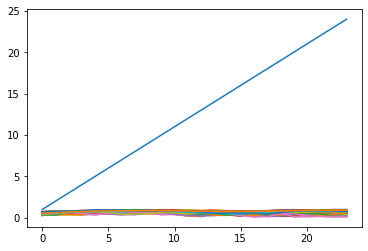

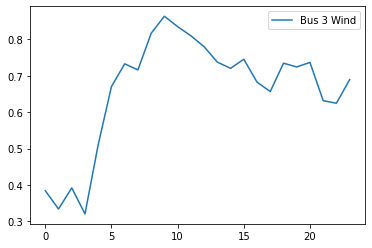

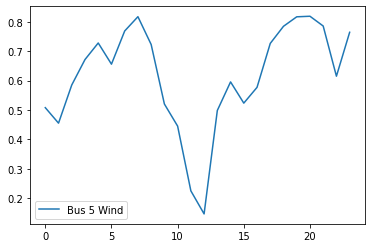

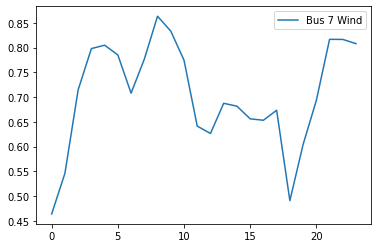

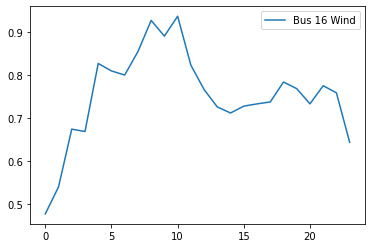

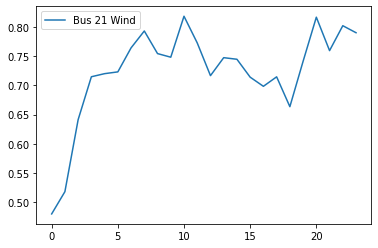

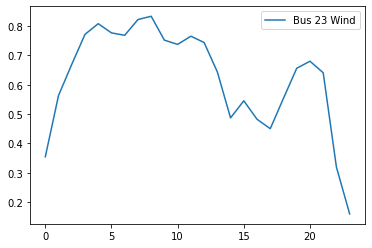

In [29]:
df_renew['mean'] = df_renew.mean(axis=1)

plt.plot(df_renew)
plt.show()

#Bus 3 renewable:
ren_bus3 = df_renew['V1']
plt.plot(ren_bus3)
plt.legend(['Bus 3 Wind'])
plt.show()

#Bus 5 renewable:
ren_bus5 = df_renew['V2']
plt.plot(ren_bus5)
plt.legend(['Bus 5 Wind'])
plt.show()

#Bus 7 renewable:
ren_bus7 = df_renew['V3']
plt.plot(ren_bus7)
plt.legend(['Bus 7 Wind'])
plt.show()

#Bus 16 renewable:
ren_bus16 = df_renew['V4']
plt.plot(ren_bus16)
plt.legend(['Bus 16 Wind'])
plt.show()

#Bus 21 renewable:
ren_bus21 = df_renew['V5']
plt.plot(ren_bus21)
plt.legend(['Bus 21 Wind'])
plt.show()

#Bus 23 renewable:
ren_bus23 = df_renew['V6']
plt.plot(ren_bus23)
plt.legend(['Bus 23 Wind'])
plt.show()


In [ ]:
# Initialize Gurobi model
model = gp.Model('Copperplate')

#Time of day:
time = 13
T = len(df_load)

#Constants
cap_re = 200 #Capacity on the renewable generators

N_d = len(df_demand) #Total number of loads
N_gen = len(df_genTech) # Total number of generators
N_ren = 6 # Total number of renewable generators

# Variables
Pgen = model.addVars(T,N_gen, vtype=gp.GRB.CONTINUOUS, name="P_gen")
Pd = model.addVars(T,N_d, vtype=gp.GRB.CONTINUOUS, name="P_demand")
Pw = model.addVars(T,N_ren, vtype = gp.GRB.CONTINUOUS, name="P_wind")


# Demand Capacity Constraints
model.addConstrs((Pd[t,d] <= df_demand.loc[d,"Percent"] * df_load.loc[t,"Demand"]
                for d in range(N_d)
                for t in range(T)), name ="Demand Max Capacity")

model.addConstrs((Pd[t,d] >= 0
                for d in range(N_d)
                for t in range(T)), name ="Demand Min Capacity")

# Generator Capacity Constraints
model.addConstrs((Pgen[t,gen] <= df_genTech.loc[gen,"Pmax"]
                for gen in range(N_gen)
                for t in range(T)), name ="Generator Max Capacity")

model.addConstrs((Pgen[t,gen] >= df_genTech.loc[gen,"Pmin"]
                for gen in range(N_gen)
                for t in range(t)), name ="Generator Min Capacity")

# Renewable Capacity Constraints
model.addConstrs((Pw[t,ren] <= df_renew.iloc[t,1 + ren] * cap_re
                for ren in range(N_ren)
                for t in range(T)), name ="Renewable Max Capacity")

model.addConstrs((Pw[t,ren] >= 0
                for ren in range(N_ren)
                for t in range(T)), name ="Renewable Min Capacity")


# Power balance constraint
model.addConstr(sum(Pgen[gen] for gen in range(N_gen))
              + sum(Pw[ren] for ren in range(N_ren)) 
              - sum(Pd[d] for d in range(N_d)) == 0, name="Power Balance")


# Objective function
model.setObjective(sum(Pd[d] * df_utility.iloc[time,1+d] for d in range(N_d))
                 - sum(Pgen[gen] * df_gen.loc[gen,"Ci"] for gen in range(N_gen))
                 - sum(Pw[ren] * 0 for ren in range(N_ren)), sense=GRB.MAXIMIZE)

model.update()

# Solve the optimization problem
model.optimize()






Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 5 6600U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 71 rows, 35 columns and 105 nonzeros
Model fingerprint: 0x981ed7fc
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+04]
Presolve removed 71 rows and 35 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4768265e+05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.476826547e+05
